In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [57]:
# define the runtime and number of time steps
RUNTIME = 1
NUM_STEPS = 1001

# define cavity coupling strength
g0 = 2*np.pi * 1

# define simulation time grid
time_steps = np.linspace(0, RUNTIME, NUM_STEPS)

# define decay rates
kappa_H = 2*np.pi * 0 # horizontal polarisation decay out of cavity
kappa_V = 2*np.pi * 0 # vertical polarisation out of cavity
gamma = 2*np.pi * 0 # spontaneous decay of excited atom

# define Raman detuning for photon production
delta_offset_STIRAP = 2*np.pi * 1

# define decouplings
delta_C = delta_offset_STIRAP # cavity decoupling
delta_L = delta_offset_STIRAP # laser decoupling

# define the birefringence splitting of cavity modes
deltaP = 2*np.pi * 0

# define the laser frequency
l_freq = 2.5*g0 - delta_L


# define laser profile
def rabi_freq(t, arg):
    
    return l_freq

In [58]:
# define dimension of truncated Fock basis
NUM_FOCK_STATES = 2

# define atomic basis states, defining a bin dimension to make it easier to define collapse operators
atom_states = {
    'bin': 0,
    'gM': 1,
    'gP': 2,
    'x': 3
}
# count the number of atomic energy levels
NUM_ATOMIC = len(atom_states)

# define quantisation axis, 'C', 'H', 'V'
quant_axis = 'C'

# name allowed polarisation states:
#   * p1 = sigP, H or X
#   * p2 = sigM, V or Y
#   * p3 = pi, C or Z
pol_states = {
    'p1': 0,
    'p2': 1,
    'p3': 2,
    'nopol': 3
    }
# count the number of polarisation states
NUM_POL = len(pol_states)

In [59]:
# define ket and bra functions (named to avoid confusion with inbuilt functions)

def cust_ket(atom_state, photon_num, pol_state):
    # takes the direct product of each state to create a single state in the wider direct product space
    return tensor(basis(NUM_ATOMIC, atom_states[atom_state]), basis(NUM_FOCK_STATES, photon_num), basis(NUM_POL, pol_states[pol_state]))

def cust_bra(atom_state, photon_num, polarisation):
    return cust_ket(atom_state, photon_num, polarisation).dag()

# initialise ket and bra lists
kets = {}
bras = {}

# define each possible basis state from the lists of the atomic levels, possible numbers of cavity photons and polarisation states
for a_state in atom_states:
    for p_num in range(NUM_FOCK_STATES):
        for pol in pol_states:
    
            kets[f'{a_state}_{p_num}_{pol}'] = cust_ket(a_state, p_num, pol)
            bras[f'{a_state}_{p_num}_{pol}'] = cust_bra(a_state, p_num, pol)

# define all possible ketbras and compile into list
ketbras = {}
for kkey in kets:
    for bkey in bras:
        ketbras[f'{kkey}_X_{bkey}'] = kets[kkey] * bras[bkey]


In [60]:
# define initial state

# define any applicable polarisation of the initial state
pol0 = [0,1,0]
pol_norm = sum([pol**2 for pol in pol0]) ** 0.5

# define idealised levels g, u and e
g_ket = 1/pol_norm * (pol0[0]*kets['gM_1_p1'] + pol0[1]*kets['gM_1_p2'] + pol0[2]*kets['gM_1_p3'])
u_ket = kets['gP_0_nopol']
e_ket = kets['x_0_nopol']

# dark state calc
print(l_freq/(2*g0))
theta = np.arctan(l_freq/(2*g0))
print(theta)
sin_theta = np.sin(theta)
cos_theta = np.cos(theta)
psi0 = cos_theta*u_ket + sin_theta*g_ket

print(sin_theta)

0.75
0.6435011087932844
0.6


In [61]:
# define atom-to-cavity polarisation basis changes {|pi>,|sigP>,|sigM>} --> {|H>,|V>,|C>} allowing for choice of
# quantisation axis

# if axis is C
atom_to_cav_BC_C_pol_subspace = 1/(np.sqrt(2))*Qobj([
    [1,1,0,0],
    [1j,-1j,0,0],
    [0,0,np.sqrt(2),0],
    [0,0,0,np.sqrt(2)]
])

# if axis is V
atom_to_cav_BC_V_pol_subspace = 1/(np.sqrt(2))*Qobj([
    [1,0,1,0],
    [1j,0,-1j,0],
    [0,np.sqrt(2),0,0],
    [0,0,0,np.sqrt(2)]
])

# if axis is H
atom_to_cav_BC_H_pol_subspace = 1/(np.sqrt(2))*Qobj([
    [0,1,1,0],
    [0,1j,-1j,0],
    [np.sqrt(2),0,0,0],
    [0,0,0,np.sqrt(2)]
])

# use polarisation basis matrices above to define the respective operators on the fulll direct product space
atom_to_cav_BC_C = tensor(qeye(NUM_ATOMIC), qeye(NUM_FOCK_STATES), atom_to_cav_BC_C_pol_subspace)
atom_to_cav_BC_V = tensor(qeye(NUM_ATOMIC), qeye(NUM_FOCK_STATES), atom_to_cav_BC_V_pol_subspace)
atom_to_cav_BC_H = tensor(qeye(NUM_ATOMIC), qeye(NUM_FOCK_STATES), atom_to_cav_BC_H_pol_subspace)

# choose correct operator for the chosen quantisation axis
if quant_axis == 'C':
    atom_to_cav_BC = atom_to_cav_BC_C
elif quant_axis == 'V':
    atom_to_cav_BC = atom_to_cav_BC_V
elif quant_axis == 'H':
    atom_to_cav_BC = atom_to_cav_BC_H


In [62]:
# define dressed state expectation ops

# initialise list
atom_ops = {}
# add to list operators with the form of a sum of density matrices of pure states with the sum being across all 
# polarisation states as these operators are for measuring the dressed state of the system irrespective of photon polarisation
for level in atom_states:
    for p_num in range(NUM_FOCK_STATES):
        atom_ops[f'{level}_{p_num}_op'] = sum([ketbras[f'{level}_{p_num}_{pol}_X_{level}_{p_num}_{pol}'] for pol in pol_states])

print(expect(atom_ops['gM_1_op'], psi0))

# define collapse operators
# cavity decay - this can happen for any state with p_num > 0, these are defined by the direct product of the identity
# of the atomic levels space, the annihilation operator of the Fock space and the relevant density matrix in the
# polarisation subspace
H_annihilation = tensor(qeye(NUM_ATOMIC), destroy(NUM_FOCK_STATES), basis(NUM_POL, 0)*basis(NUM_POL,0).dag())
V_annihilation = tensor(qeye(NUM_ATOMIC), destroy(NUM_FOCK_STATES), basis(NUM_POL, 1)*basis(NUM_POL,1).dag())
# the overall decay operator is the sum of the square roots of the decay rates times the annihilation operators sandwiched
# in a similarity transform in order for them to operate in the correct polarisation basis. The polarisation state is
# unchanged so we keep account of the pol state of the emitted photon
cav_decay_op = np.sqrt(kappa_H)*atom_to_cav_BC.dag()*H_annihilation*atom_to_cav_BC + np.sqrt(kappa_V)*atom_to_cav_BC.dag()*V_annihilation*atom_to_cav_BC

# spontaneous decay, |x> --> |gM>
x_decay = tensor(basis(NUM_ATOMIC, 1)*basis(NUM_ATOMIC,3).dag(), qeye(NUM_FOCK_STATES), qeye(NUM_POL))
spont_decay_op = np.sqrt(gamma)*x_decay

# compile collapse operators into a list
c_ops = [spont_decay_op, cav_decay_op]


0.36


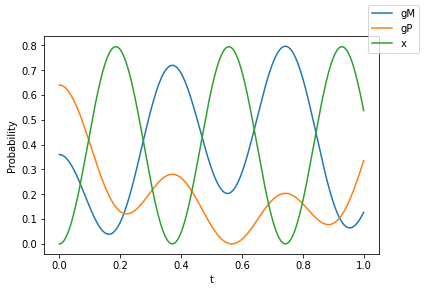

In [63]:
# define Hamiltonian suboperators
# ground states density matrices
gM_dm = sum([ketbras[f'gM_1_{pol}_X_gM_1_{pol}'] for pol in pol_states])
gP_dm = sum([ketbras[f'gP_0_{pol}_X_gP_0_{pol}'] for pol in pol_states])

# ground states to excited state operators
gP_x_swap = tensor(basis(NUM_ATOMIC, 3)*basis(NUM_ATOMIC, 2).dag(), basis(NUM_FOCK_STATES,0)*basis(NUM_FOCK_STATES,0).dag(), qeye(NUM_POL))
gM_x_swap = tensor(basis(NUM_ATOMIC, 3)*basis(NUM_ATOMIC,1).dag(), basis(NUM_FOCK_STATES,0)*basis(NUM_FOCK_STATES, 1).dag(), basis(NUM_POL,3)*basis(NUM_POL,1).dag())

# off_res_gM_x_swap = sum([ketbras['x_0_p3_X_bgM_{pol}'] for pol in pol_states])
# off_res_gP_x_swap = 

H0 = delta_C*gM_dm + delta_L*gP_dm - g0*(gM_x_swap + gM_x_swap.dag())
H1 = -1/2*(gP_x_swap + gP_x_swap.dag())

H = [H0, [H1, rabi_freq]]
resultant_states = mesolve(H, psi0, time_steps, c_ops, [])

# plot expectations of the measurements of each state
fig, axes = plt.subplots(1,1)
axes.plot(time_steps, expect(atom_ops['gM_1_op'], resultant_states.states))
axes.plot(time_steps, expect(atom_ops['gP_0_op'], resultant_states.states))
axes.plot(time_steps, expect(atom_ops['x_0_op'], resultant_states.states))
    
axes.set_xlabel('t')
axes.set_ylabel('Probability')

fig.legend(['gM','gP','x'])